In [1]:

%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np 
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from imview import pltlib
import pandas as pd
from pygeotools.lib import warplib,geolib,iolib,malib,filtlib,timelib
import os,sys,glob,shutil
from debris_cover_smb import glac_dyn, constants, geospatial
import warnings
from demcoreg import dem_mask
from scipy.optimize import curve_fit
import xdem
warnings.filterwarnings('ignore')

In [3]:
%matplotlib inline

In [106]:
%cd /nobackup/sbhusha1/chapter2/HighresDebrisCover_SMB_Data/Ngozumpa/SMB_data/

/nobackupp11/sbhusha1/chapter2/HighresDebrisCover_SMB_Data/Ngozumpa/SMB_data


In [5]:
weights = np.array([0.22,0.19,0.18,0.28])
print(weights.sum())
norm_weights = weights/weights.sum()
print(norm_weights.sum())

0.8700000000000001
1.0


In [6]:
def compute_stack_wt_std(flux_models,norm_weights=norm_weights):
    #https://stackoverflow.com/questions/2413522/weighted-standard-deviation-in-numpy
    flux_models = np.ma.stack(flux_models)
    wt_average = np.ma.average(flux_models,axis=0,weights=norm_weights)
    variance = np.ma.average((flux_models-wt_average)**2,axis=0, weights=norm_weights)
    std = np.ma.sqrt(variance)
    return std

In [52]:
vx_fn = '20121223_combined_hs__20150115_combined_hs_mgm_disp_9spm_spm_ker15_corr_kernel9px_resmin_txm_vx_skiprate_1_gauss_fill51px_shpclip.tif'
vy_fn = '20121223_combined_hs__20150115_combined_hs_mgm_disp_9spm_spm_ker15_corr_kernel9px_resmin_txm_vy_skiprate_1_gauss_fill51px_shpclip.tif'
dem1_fn = '../dem/20121223_0456_1050410000E0AE00_1050410000E8C900-DEM_2m.tif'
dem2_fn = '../dem/20150115_0456_1040010006A12900_104001000665F400-DEM_2m_align.tif'
smb_fn = 'ngozumpa_farinotti_2012-12-23_to_2015-01-15_smb_dhdt.tif'
glac_name = 'ngozumpa'
H_con = constants.fetch_farinotti_thickness(glac_name)
model1_thickness_fn = glob.glob(f"{constants.data_dir}/farinotti_2019_ice_thickness/model{1}/RGI60-15/thickness_{constants.rgi_dicts[glac_name]}.tif")[0]
model2_thickness_fn = glob.glob(f"{constants.data_dir}/farinotti_2019_ice_thickness/model{2}/RGI60-15/thickness_{constants.rgi_dicts[glac_name]}.tif")[0]
model3_thickness_fn = glob.glob(f"{constants.data_dir}/farinotti_2019_ice_thickness/model{3}/RGI60-15/thickness_{constants.rgi_dicts[glac_name]}.tif")[0]
model4_thickness_fn = glob.glob(f"{constants.data_dir}/farinotti_2019_ice_thickness/model{4}/RGI60-15/thickness_{constants.rgi_dicts[glac_name]}.tif")[0]
divq2_concensus_fn = 'ngozumpa_farinotti_2012-12-23_to_2015-01-15_divQ2.tif'
f = 0.8
ds_list = warplib.memwarp_multi_fn([vx_fn,vy_fn,H_con,model1_thickness_fn,model2_thickness_fn,model3_thickness_fn,model4_thickness_fn,divq2_concensus_fn],extent='last',res='last')
vx,vy,H_con,H_model1,H_model2,H_model3,H_model4,divq2_con = [iolib.ds_getma(ds) for ds in ds_list]

vx = f * vx                                
vy = f * vy
vm = np.ma.sqrt(vx**2+vy**2)
icemask = dem_mask.get_icemask(ds_list[0])


Warping all inputs to the following:
Resolution: 50.0
Extent: [466125.0, 3089921.0, 476775.0, 3104071.0]
Projection: '+proj=utm +zone=45 +datum=WGS84 +units=m +no_defs'
Resampling alg: cubic

1 of 8: 20121223_combined_hs__20150115_combined_hs_mgm_disp_9spm_spm_ker15_corr_kernel9px_resmin_txm_vx_skiprate_1_gauss_fill51px_shpclip.tif
nl: 283 ns: 213 res: 50.000
100 - done.
0...10...20...30...40...50...60...70...80...90...2 of 8: 20121223_combined_hs__20150115_combined_hs_mgm_disp_9spm_spm_ker15_corr_kernel9px_resmin_txm_vy_skiprate_1_gauss_fill51px_shpclip.tif
nl: 283 ns: 213 res: 50.000
100 - done.
0...10...20...30...40...50...60...70...80...90...3 of 8: /nobackupp11/sbhusha1/reference_data/farinotti_2019_ice_thickness/RGI60-15/RGI60-15.03473_thickness.tif
nl: 283 ns: 213 res: 50.000
100 - done.
0...10...20...30...40...50...60...70...80...90...4 of 8: /nobackupp11/sbhusha1/reference_data//farinotti_2019_ice_thickness/model1/RGI60-15/thickness_RGI60-15.03473.tif
nl: 283 ns: 213 res: 50.

<Axes: title={'center': 'Median: 0.41\n NMAD: 0.14'}>

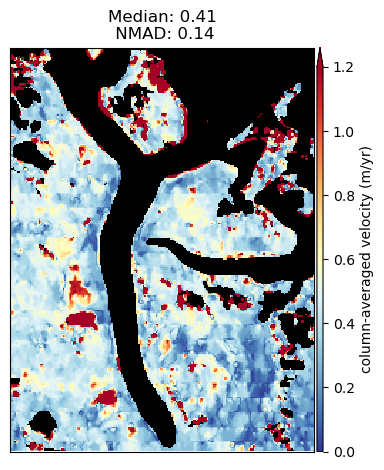

In [21]:
static_vm = np.ma.array(vm,mask=~icemask)
nmad,median = malib.mad(static_vm,return_med=True)
title = f"Median: {median:.2f}\n NMAD: {nmad:.2f}"
pltlib.iv(static_vm,cmap="RdYlBu_r",clim=(0,1.2),title=title,label="column-averaged velocity (m/yr)")

<Axes: >

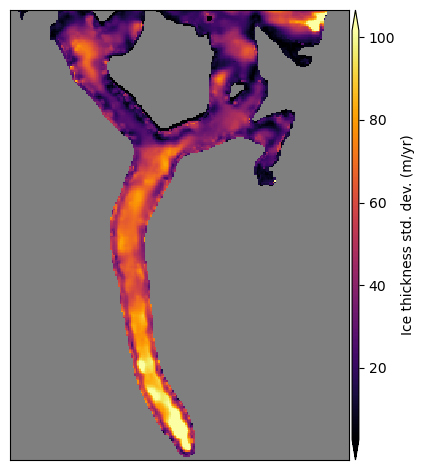

In [20]:
H_list = [H_model1,H_model2,H_model3,H_model4]
common_mask = malib.common_mask(H_list)
H_list = [np.ma.array(H,mask=common_mask) for H in H_list]
icethickness_std = compute_stack_wt_std(H_list)
pltlib.iv(icethickness_std,cmap='inferno',label='Ice thickness std. dev. (m/yr)')

In [104]:
def compute_flux_divergence_uncertainty(vm,icemask,H_list,H_con,divq2,norm_weights=norm_weights):
    static_vm = np.ma.array(vm,mask=~icemask)
    nmad,median = malib.mad(static_vm,return_med=True)
    title = f"Median: {median:.2f}\n NMAD: {nmad:.2f}"
    pltlib.iv(static_vm,cmap="RdYlBu_r",clim=(0,1.2),title=title,label="column-averaged velocity (m/yr)")
    vm_relative_uncertainty = np.ma.array(np.ma.sqrt(nmad**2+median**2)/vm,mask=icemask)
    #common_mask = malib.common_mask(H_list)
    #H_list = [np.ma.array(H,mask=common_mask) for H in H_list]
    H_std = compute_stack_wt_std(H_list,norm_weights)
    H_std = np.ma.array(H_std,mask=H_con.mask)
    pltlib.iv(H_std,cmap='inferno',label='Ice thickness std. dev. (m/yr)')
    H_relative_uncertainty = H_std/H_con
    relative_divq2_uncertainty = np.ma.sqrt(H_relative_uncertainty**2+vm_relative_uncertainty**2)
    divq2_uncertainty = np.ma.abs(divq2)*relative_divq2_uncertainty
    pltlib.iv(divq2_uncertainty,cmap='inferno',clim=(0,1.2),label=r'$\sigma (\mathrm{f}\;\nabla{\cdot}(H\mathbf{u_{s}}))$')
    return divq2_uncertainty

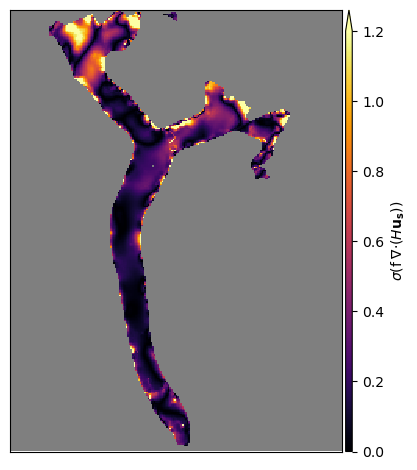

In [40]:
divq2_uncertainty = compute_flux_divergence_uncertainty(vm,icemask,[H_model1,H_model2, H_model3, H_model4],H_con,divq2_con)
divq2_uncertainty_fn = os.path.splitext(divq2_concensus_fn)[0]+"_divq2_uncertainty_propagated.tif"
iolib.writeGTiff(divq2_uncertainty,divq2_uncertainty_fn,src_ds=ds_list[-1])

In [68]:
ds_list_highres = warplib.memwarp_multi_fn([dem1_fn,dem2_fn,vx_fn,vy_fn,divq2_uncertainty_fn,smb_fn])
dem1,dem2,vx_highres,vy_highres,divq2_uncertainty_highres,smb = [iolib.ds_getma(ds) for ds in ds_list_highres]
icemask_highres = dem_mask.get_icemask(ds_list_highres[0])
ds_extent = geolib.ds_extent(ds_list_highres[0])
fig_extent = [ds_extent[0],ds_extent[2],ds_extent[1],ds_extent[3]]
res_high = geolib.get_res(ds_list_highres[0])[0]
dt = timelib.get_t_factor_fn(dem1_fn,dem2_fn)
lag_dhdt = glac_dyn.compute_lagrangian(dem1,dem2,vx_highres,vy_highres,dt,annual=True,res=res_high)
slope_parallel_dhdt = glac_dyn.compute_along_slope_flow_correction_working(dem1,vx_highres,vy_highres,dt,annual=True,res=res_high,smooth=False)
slope_corrected_lag_dhdt = lag_dhdt - slope_parallel_dhdt
slope_corrected_static = np.ma.array(slope_corrected_lag_dhdt,mask=~icemask_highres)
median,nmad = malib.mad(slope_corrected_static,return_med=True)
slope_corrected_static_uncertainty = np.ma.sqrt(median**2+nmad**2)
slope_corrected_static_uncertainty_map_view = np.ma.zeros_like(divq2_uncertainty_highres)+slope_corrected_static_uncertainty
smb_uncertainty = np.ma.sqrt(slope_corrected_static_uncertainty_map_view**2+divq2_uncertainty_highres**2)
smb_uncertainty_fn = os.path.splitext(smb_fn)[0]+"_smb_propagated_uncertainty.tif"
iolib.writeGTiff(smb_uncertainty,smb_uncertainty_fn,src_ds=ds_list_highres[0])


Warping all inputs to the following:
Resolution: 2.0
Extent: [466125.0, 3089921.0, 476775.0, 3104071.0]
Projection: '+proj=utm +zone=45 +datum=WGS84 +units=m +no_defs'
Resampling alg: cubic

1 of 6: ../dem/20121223_0456_1050410000E0AE00_1050410000E8C900-DEM_2m.tif
nl: 7075 ns: 5325 res: 2.000
100 - done.
0...10...20...30...40...50...60...70...80...90...2 of 6: ../dem/20150115_0456_1040010006A12900_104001000665F400-DEM_2m_align.tif
nl: 7075 ns: 5325 res: 2.000
100 - done.
0...10...20...30...40...50...60...70...80...90...3 of 6: 20121223_combined_hs__20150115_combined_hs_mgm_disp_9spm_spm_ker15_corr_kernel9px_resmin_txm_vx_skiprate_1_gauss_fill51px_shpclip.tif
nl: 7075 ns: 5325 res: 2.000
100 - done.
0...10...20...30...40...50...60...70...80...90...4 of 6: 20121223_combined_hs__20150115_combined_hs_mgm_disp_9spm_spm_ker15_corr_kernel9px_resmin_txm_vy_skiprate_1_gauss_fill51px_shpclip.tif
nl: 7075 ns: 5325 res: 2.000
100 - done.
0...10...20...30...40...50...60...70...80...90...5 of 6: ng

In [73]:

def propagate_full_uncertainty(vx_fn,vy_fn,dem1_fn,dem2_fn,smb_fn,divq2_concensus_fn,glac_name):
    H_con = constants.fetch_farinotti_thickness(glac_name)
    model1_thickness_fn = glob.glob(f"{constants.data_dir}/farinotti_2019_ice_thickness/model{1}/RGI60-15/thickness_{constants.rgi_dicts[glac_name]}.tif")[0]
    model2_thickness_fn = glob.glob(f"{constants.data_dir}/farinotti_2019_ice_thickness/model{2}/RGI60-15/thickness_{constants.rgi_dicts[glac_name]}.tif")[0]
    model3_thickness_fn = glob.glob(f"{constants.data_dir}/farinotti_2019_ice_thickness/model{3}/RGI60-15/thickness_{constants.rgi_dicts[glac_name]}.tif")[0]
    model4_thickness_fn = glob.glob(f"{constants.data_dir}/farinotti_2019_ice_thickness/model{4}/RGI60-15/thickness_{constants.rgi_dicts[glac_name]}.tif")[0]
    f = 0.8
    ds_list = warplib.memwarp_multi_fn([vx_fn,vy_fn,H_con,model1_thickness_fn,model2_thickness_fn,model3_thickness_fn,model4_thickness_fn,divq2_concensus_fn],extent='last',res='last')
    vx,vy,H_con,H_model1,H_model2,H_model3,H_model4,divq2_con = [iolib.ds_getma(ds) for ds in ds_list]
    
    vx = f * vx                                
    vy = f * vy
    vm = np.ma.sqrt(vx**2+vy**2)
    icemask = dem_mask.get_icemask(ds_list[0])
    
    print("computing flux divergence uncertainty")
    divq2_uncertainty = compute_flux_divergence_uncertainty(vm,icemask,[H_model1,H_model2, H_model3, H_model4],H_con,divq2_con)
    divq2_uncertainty_fn = os.path.splitext(divq2_concensus_fn)[0]+"_uncertainty_propagated.tif"
    iolib.writeGTiff(divq2_uncertainty,divq2_uncertainty_fn,src_ds=ds_list[-1])
    ds_list_highres = warplib.memwarp_multi_fn([dem1_fn,dem2_fn,vx_fn,vy_fn,divq2_uncertainty_fn,smb_fn])
    dem1,dem2,vx_highres,vy_highres,divq2_uncertainty_highres,smb = [iolib.ds_getma(ds) for ds in ds_list_highres]
    icemask_highres = dem_mask.get_icemask(ds_list_highres[0])
    ds_extent = geolib.ds_extent(ds_list_highres[0])
    fig_extent = [ds_extent[0],ds_extent[2],ds_extent[1],ds_extent[3]]
    res_high = geolib.get_res(ds_list_highres[0])[0]
    dt = timelib.get_t_factor_fn(dem1_fn,dem2_fn)
    lag_dhdt = glac_dyn.compute_lagrangian(dem1,dem2,vx_highres,vy_highres,dt,annual=True,res=res_high)
    slope_parallel_dhdt = glac_dyn.compute_along_slope_flow_correction_working(dem1,vx_highres,vy_highres,dt,annual=True,res=res_high,smooth=False)
    slope_corrected_lag_dhdt = lag_dhdt - slope_parallel_dhdt
    slope_corrected_static = np.ma.array(slope_corrected_lag_dhdt,mask=~icemask_highres)
    median,nmad = malib.mad(slope_corrected_static,return_med=True)
    slope_corrected_static_uncertainty = np.ma.sqrt(median**2+nmad**2)
    slope_corrected_static_uncertainty_map_view = np.ma.zeros_like(divq2_uncertainty_highres)+slope_corrected_static_uncertainty
    smb_uncertainty = np.ma.sqrt(slope_corrected_static_uncertainty_map_view**2+divq2_uncertainty_highres**2)
    smb_uncertainty_fn = os.path.splitext(smb_fn)[0]+"_smb_propagated_uncertainty.tif"
    iolib.writeGTiff(smb_uncertainty,smb_uncertainty_fn,src_ds=ds_list_highres[0])
    
    f,ax = plt.subplots(1,2)
    pltlib.iv(smb,ax=ax[0],cmap='RdBu',clim=(-4,4),hillshade=True,ds=ds_list_highres[0],scalebar=False,extent=fig_extent,
          skinny=False,label=r'$\frac{\dot{b}}{\rho}\;(m/yr)$ ',full_bg_stretch=False,overlay_alpha=1)
    pltlib.iv(smb_uncertainty,ax=ax[1],cmap='inferno',clim=(0,1),hillshade=True,ds=ds_list_highres[0],scalebar=False,extent=fig_extent,
          skinny=False,label=r'$\sigma\;(\frac{\dot{b}}{\rho}\;(m/yr))$ ',full_bg_stretch=False,overlay_alpha=1)
    return smb_uncertainty

In [107]:
vx_fn = '20121223_combined_hs__20150115_combined_hs_mgm_disp_9spm_spm_ker15_corr_kernel9px_resmin_txm_vx_skiprate_1_gauss_fill51px_shpclip.tif'
vy_fn = '20121223_combined_hs__20150115_combined_hs_mgm_disp_9spm_spm_ker15_corr_kernel9px_resmin_txm_vy_skiprate_1_gauss_fill51px_shpclip.tif'
dem1_fn = '../dem/20121223_0456_1050410000E0AE00_1050410000E8C900-DEM_2m.tif'
dem2_fn = '../dem/20150115_0456_1040010006A12900_104001000665F400-DEM_2m_align.tif'
divq2_concensus_fn = 'ngozumpa_farinotti_2012-12-23_to_2015-01-15_divQ2.tif'
smb_fn = 'ngozumpa_farinotti_2012-12-23_to_2015-01-15_smb_dhdt.tif'
glac_name = 'ngozumpa'


Warping all inputs to the following:
Resolution: 50.0
Extent: [466125.0, 3089921.0, 476775.0, 3104071.0]
Projection: '+proj=utm +zone=45 +datum=WGS84 +units=m +no_defs'
Resampling alg: cubic

1 of 8: 20121223_combined_hs__20150115_combined_hs_mgm_disp_9spm_spm_ker15_corr_kernel9px_resmin_txm_vx_skiprate_1_gauss_fill51px_shpclip.tif
nl: 283 ns: 213 res: 50.000
100 - done.
0...10...20...30...40...50...60...70...80...90...2 of 8: 20121223_combined_hs__20150115_combined_hs_mgm_disp_9spm_spm_ker15_corr_kernel9px_resmin_txm_vy_skiprate_1_gauss_fill51px_shpclip.tif
nl: 283 ns: 213 res: 50.000
100 - done.
0...10...20...30...40...50...60...70...80...90...3 of 8: /nobackupp11/sbhusha1/reference_data/farinotti_2019_ice_thickness/RGI60-15/RGI60-15.03473_thickness.tif
nl: 283 ns: 213 res: 50.000
100 - done.
0...10...20...30...40...50...60...70...80...90...4 of 8: /nobackupp11/sbhusha1/reference_data//farinotti_2019_ice_thickness/model1/RGI60-15/thickness_RGI60-15.03473.tif
nl: 283 ns: 213 res: 50.

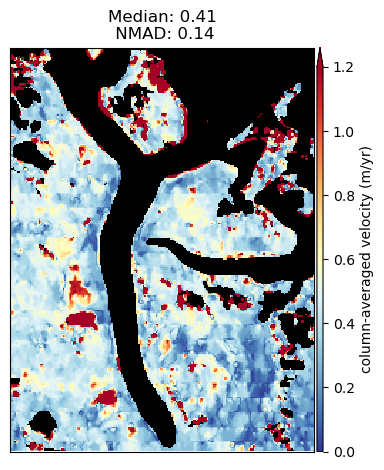

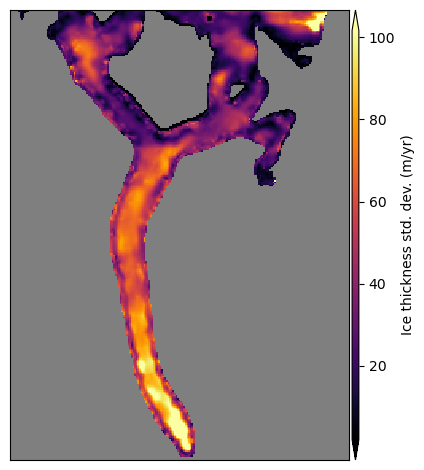

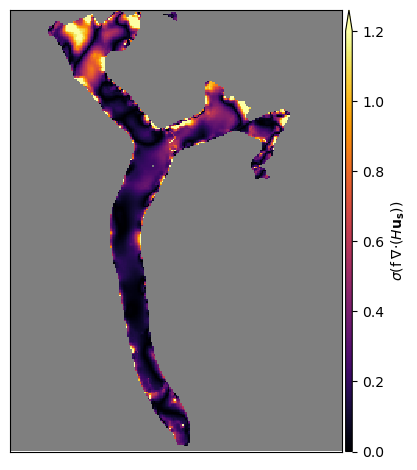

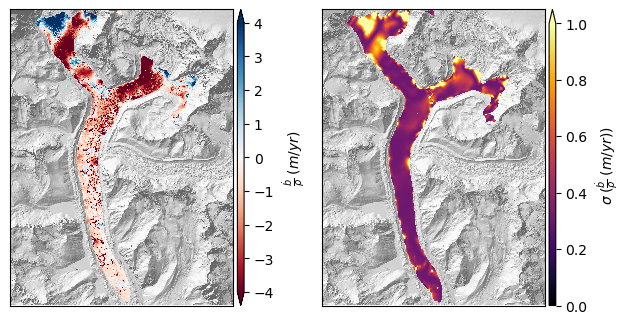

In [108]:
ngozumpa_smb_uncertainty = propagate_full_uncertainty(vx_fn,vy_fn,dem1_fn,dem2_fn,smb_fn,divq2_concensus_fn,glac_name='ngozumpa')

## Imja

In [109]:
%cd /nobackup/sbhusha1/chapter2/HighresDebrisCover_SMB_Data/ImjaLhotseShar/SMB_data/

/nobackupp11/sbhusha1/chapter2/HighresDebrisCover_SMB_Data/ImjaLhotseShar/SMB_data


In [110]:
vx_fn = '20151002_combined_hs_masked__20161029_combined_hs_masked_mgm_disp_9spm_spm_ker15_corr_kernel9px_resmin_txm_vx_skiprate_1_gauss_fill51px_shpclip_1.tif'
vy_fn = '20151002_combined_hs_masked__20161029_combined_hs_masked_mgm_disp_9spm_spm_ker15_corr_kernel9px_resmin_txm_vy_skiprate_1_gauss_fill51px_shpclip_1.tif'
dem1_fn = '../dem/20151002_0651_10200100457F0C00_1020010042C0CE00-DEM_2m.tif'
dem2_fn = '../dem/20161029_0451_103001005E3EFF00_103001005E3A0D00-DEM_2m_align.tif'
divq2_concensus_fn = 'imja_farinotti_2015-10-02_to_2016-10-29_divQ2.tif'
smb_fn = 'imja_farinotti_2015-10-02_to_2016-10-29_smb_dhdt.tif'
glac_name = 'imja'


Warping all inputs to the following:
Resolution: 25.0
Extent: [492962.5, 3084912.5, 498337.5, 3092462.5]
Projection: '+proj=utm +zone=45 +datum=WGS84 +units=m +no_defs'
Resampling alg: cubic

1 of 8: 20151002_combined_hs_masked__20161029_combined_hs_masked_mgm_disp_9spm_spm_ker15_corr_kernel9px_resmin_txm_vx_skiprate_1_gauss_fill51px_shpclip_1.tif
nl: 302 ns: 215 res: 25.000
100 - done.
0...10...20...30...40...50...60...70...80...90...2 of 8: 20151002_combined_hs_masked__20161029_combined_hs_masked_mgm_disp_9spm_spm_ker15_corr_kernel9px_resmin_txm_vy_skiprate_1_gauss_fill51px_shpclip_1.tif
nl: 302 ns: 215 res: 25.000
100 - done.
0...10...20...30...40...50...60...70...80...90...3 of 8: /nobackupp11/sbhusha1/reference_data/farinotti_2019_ice_thickness/RGI60-15/RGI60-15.03743_thickness.tif
nl: 302 ns: 215 res: 25.000
100 - done.
0...10...20...30...40...50...60...70...80...90...4 of 8: /nobackupp11/sbhusha1/reference_data//farinotti_2019_ice_thickness/model1/RGI60-15/thickness_RGI60-15.03

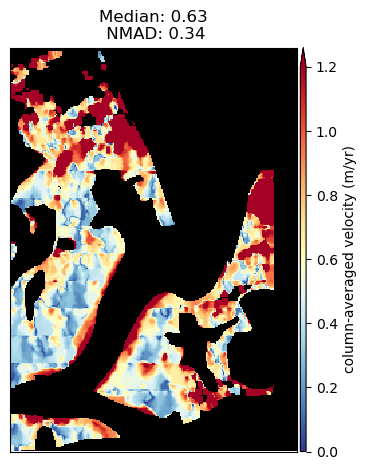

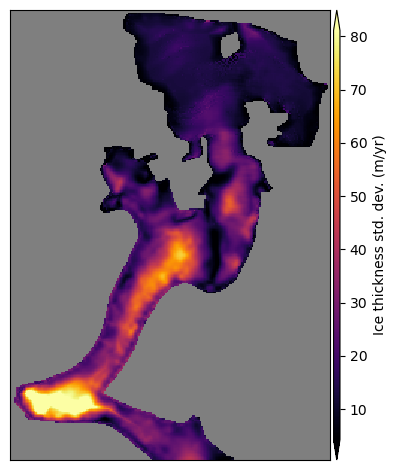

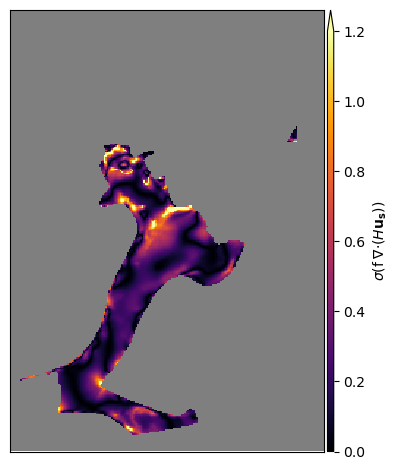

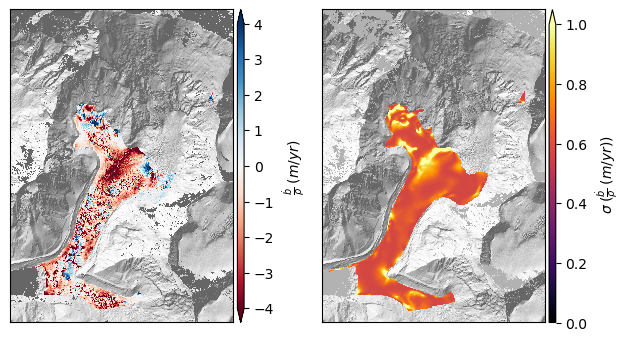

In [111]:
imja_smb_uncertainty = propagate_full_uncertainty(vx_fn,vy_fn,dem1_fn,dem2_fn,smb_fn,divq2_concensus_fn,glac_name='imja')

## Langtang

In [112]:
%cd /nobackup/sbhusha1/chapter2/HighresDebrisCover_SMB_Data/Langtang/SMB_data/

/nobackupp11/sbhusha1/chapter2/HighresDebrisCover_SMB_Data/Langtang/SMB_data


In [113]:
vx_fn = '20150222_combined_hs__20160107_combined_hs_mgm_disp_9spm_spm_ker15_corr_kernel9px_resmin_txm_vx_skiprate_1_gauss_fill51px_shpclip_1.tif'
vy_fn = '20150222_combined_hs__20160107_combined_hs_mgm_disp_9spm_spm_ker15_corr_kernel9px_resmin_txm_vy_skiprate_1_gauss_fill51px_shpclip_1.tif'
dem1_fn = '../dem/20150222_0504_1040010008B92D00_10400100087E2400-DEM_2m_align.tif'
dem2_fn = '../dem/20160107_0510_103001004F89CB00_103001004E783B00-DEM_2m.tif'
divq2_concensus_fn = 'langtang_farinotti_2015-02-22_to_2016-01-07_divQ2.tif'
smb_fn = 'langtang_farinotti_2015-02-22_to_2016-01-07_smb_dhdt.tif'
glac_name = 'langtang'


Warping all inputs to the following:
Resolution: 25.0
Extent: [368087.5, 3121737.5, 375912.5, 3139937.5]
Projection: '+proj=utm +zone=45 +datum=WGS84 +units=m +no_defs'
Resampling alg: cubic

1 of 8: 20150222_combined_hs__20160107_combined_hs_mgm_disp_9spm_spm_ker15_corr_kernel9px_resmin_txm_vx_skiprate_1_gauss_fill51px_shpclip_1.tif
nl: 728 ns: 313 res: 25.000
100 - done.
0...10...20...30...40...50...60...70...80...90...2 of 8: 20150222_combined_hs__20160107_combined_hs_mgm_disp_9spm_spm_ker15_corr_kernel9px_resmin_txm_vy_skiprate_1_gauss_fill51px_shpclip_1.tif
nl: 728 ns: 313 res: 25.000
100 - done.
0...10...20...30...40...50...60...70...80...90...3 of 8: /nobackupp11/sbhusha1/reference_data/farinotti_2019_ice_thickness/RGI60-15/RGI60-15.04121_thickness.tif
nl: 728 ns: 313 res: 25.000
100 - done.
0...10...20...30...40...50...60...70...80...90...4 of 8: /nobackupp11/sbhusha1/reference_data//farinotti_2019_ice_thickness/model1/RGI60-15/thickness_RGI60-15.04121.tif
nl: 728 ns: 313 res:

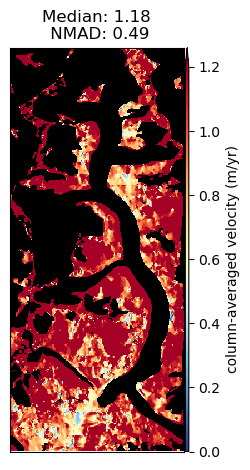

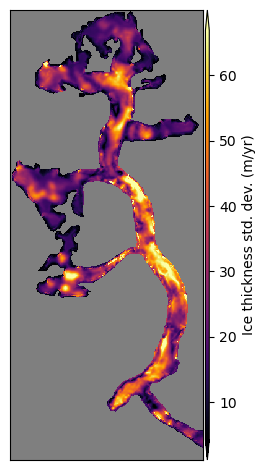

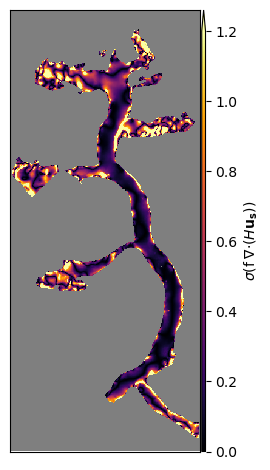

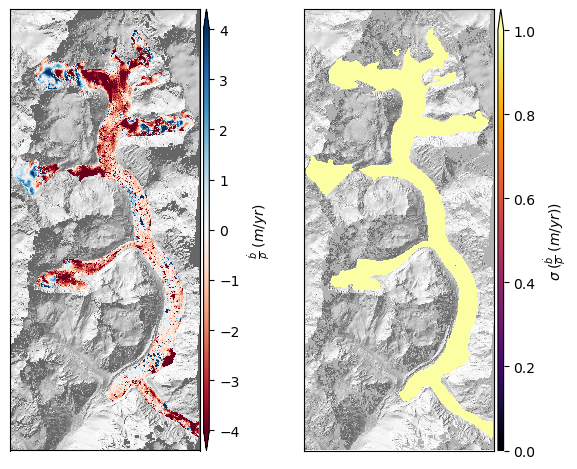

In [114]:
langtang_smb_uncertainty = propagate_full_uncertainty(vx_fn,vy_fn,dem1_fn,dem2_fn,smb_fn,divq2_concensus_fn,glac_name=glac_name)

<Axes: >

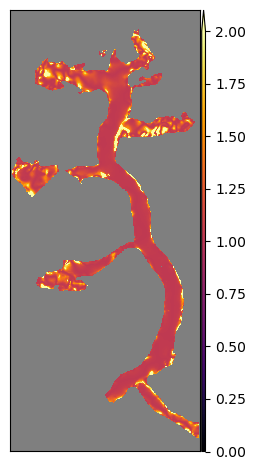

In [115]:
pltlib.iv(langtang_smb_uncertainty,cmap='inferno',clim=(0,2))

## Lirung

In [116]:
%cd /nobackup/sbhusha1/chapter2/HighresDebrisCover_SMB_Data/Lirung/SMB_data/

/nobackupp11/sbhusha1/chapter2/HighresDebrisCover_SMB_Data/Lirung/SMB_data


In [117]:
vx_fn = '20161106_combined_hs__20171222_combined_hs_mgm_disp_9spm_spm_ker15_corr_kernel9px_resmin_txm_vx_skiprate_1_1_masked_gauss_fill51px_1.tif'
vy_fn = '20161106_combined_hs__20171222_combined_hs_mgm_disp_9spm_spm_ker15_corr_kernel9px_resmin_txm_vy_skiprate_1_1_masked_gauss_fill51px_1.tif'
dem1_fn = '../dem/20161106_0456_103001005FAB7A00_103001005F7EBB00-DEM_2m_align.tif'
dem2_fn = '../dem/20171222_0807_10200100688AC000_102001006F214E00-DEM_2m_align.tif'
divq2_concensus_fn = 'lirung_farinotti_2016-11-06_to_2017-12-22_divQ2.tif'
smb_fn = 'lirung_farinotti_2016-11-06_to_2017-12-22_smb_dhdt.tif'
glac_name = 'lirung'


Warping all inputs to the following:
Resolution: 25.0
Extent: [357337.5, 3122712.5, 359212.5, 3126237.5]
Projection: '+proj=utm +zone=45 +datum=WGS84 +units=m +no_defs'
Resampling alg: cubic

1 of 8: 20161106_combined_hs__20171222_combined_hs_mgm_disp_9spm_spm_ker15_corr_kernel9px_resmin_txm_vx_skiprate_1_1_masked_gauss_fill51px_1.tif
nl: 141 ns: 75 res: 25.000
100 - done.
0...10...20...30...40...50...60...70...80...90...2 of 8: 20161106_combined_hs__20171222_combined_hs_mgm_disp_9spm_spm_ker15_corr_kernel9px_resmin_txm_vy_skiprate_1_1_masked_gauss_fill51px_1.tif
nl: 141 ns: 75 res: 25.000
100 - done.
0...10...20...30...40...50...60...70...80...90...3 of 8: /nobackupp11/sbhusha1/reference_data/farinotti_2019_ice_thickness/RGI60-15/RGI60-15.04045_thickness.tif
4 of 8: /nobackupp11/sbhusha1/reference_data//farinotti_2019_ice_thickness/model1/RGI60-15/thickness_RGI60-15.04045.tif
5 of 8: /nobackupp11/sbhusha1/reference_data//farinotti_2019_ice_thickness/model2/RGI60-15/thickness_RGI60-15

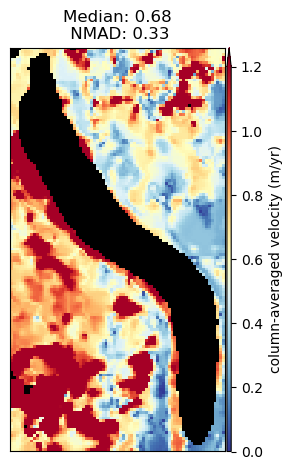

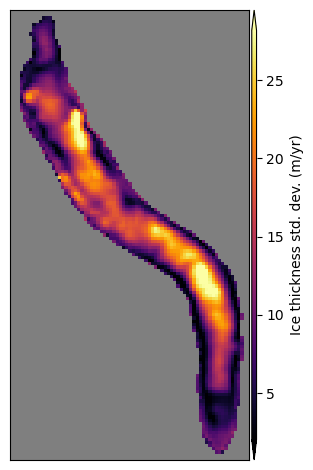

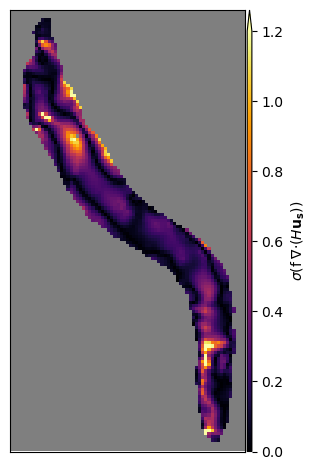

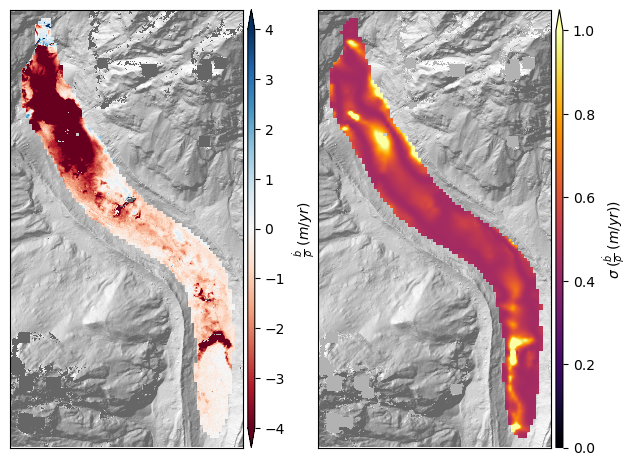

In [118]:
lirung_smb_uncertainty = propagate_full_uncertainty(vx_fn,vy_fn,dem1_fn,dem2_fn,smb_fn,divq2_concensus_fn,glac_name=glac_name)

## Khumbu

In [119]:

%cd /nobackup/sbhusha1/chapter2/HighresDebrisCover_SMB_Data/Khumbu/SMB_data/

/nobackupp11/sbhusha1/chapter2/HighresDebrisCover_SMB_Data/Khumbu/SMB_data


In [120]:
vx_fn = '20151102_combined_hs__20161025_combined_hs_mgm_disp_9spm_spm_ker15_corr_kernel9px_resmin_txm_vx_skiprate_1_gauss_fill51px_shpclip_b1.tif'
vy_fn = '20151102_combined_hs__20161025_combined_hs_mgm_disp_9spm_spm_ker15_corr_kernel9px_resmin_txm_vy_skiprate_1_gauss_fill51px_shpclip_b1.tif'
dem1_fn = '../dem/20151102_0517_10400100125E8E00_10400100130D8500_align.tif'
dem2_fn = '../dem/20161025_0524_104001002469AD00_1040010024438E00-DEM_2m_align.tif'
divq2_concensus_fn = 'khumbu_farinotti_2015-11-02_to_2016-10-25_divQ2.tif'
smb_fn = 'khumbu_farinotti_2015-11-02_to_2016-10-25_smb_dhdt.tif'
glac_name = 'khumbu'


Warping all inputs to the following:
Resolution: 25.0
Extent: [481512.5, 3090512.5, 488437.5, 3099662.5]
Projection: '+proj=utm +zone=45 +datum=WGS84 +units=m +no_defs'
Resampling alg: cubic

1 of 8: 20151102_combined_hs__20161025_combined_hs_mgm_disp_9spm_spm_ker15_corr_kernel9px_resmin_txm_vx_skiprate_1_gauss_fill51px_shpclip_b1.tif
nl: 366 ns: 277 res: 25.000
100 - done.
0...10...20...30...40...50...60...70...80...90...2 of 8: 20151102_combined_hs__20161025_combined_hs_mgm_disp_9spm_spm_ker15_corr_kernel9px_resmin_txm_vy_skiprate_1_gauss_fill51px_shpclip_b1.tif
nl: 366 ns: 277 res: 25.000
100 - done.
0...10...20...30...40...50...60...70...80...90...3 of 8: /nobackupp11/sbhusha1/reference_data/farinotti_2019_ice_thickness/RGI60-15/RGI60-15.03733_thickness.tif
nl: 366 ns: 277 res: 25.000
100 - done.
0...10...20...30...40...50...60...70...80...90...4 of 8: /nobackupp11/sbhusha1/reference_data//farinotti_2019_ice_thickness/model1/RGI60-15/thickness_RGI60-15.03733.tif
nl: 366 ns: 277 re

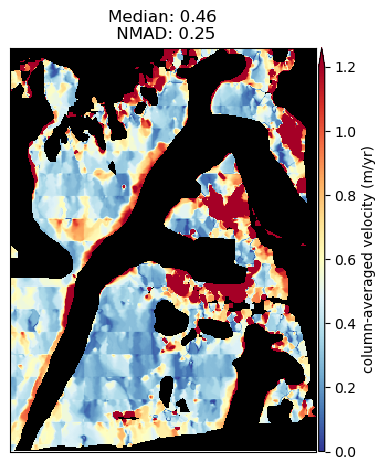

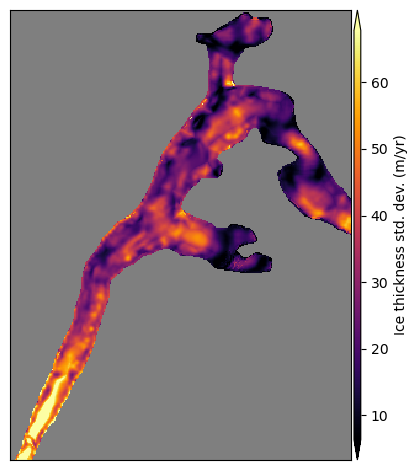

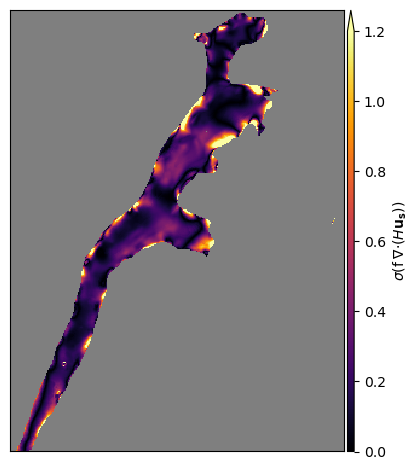

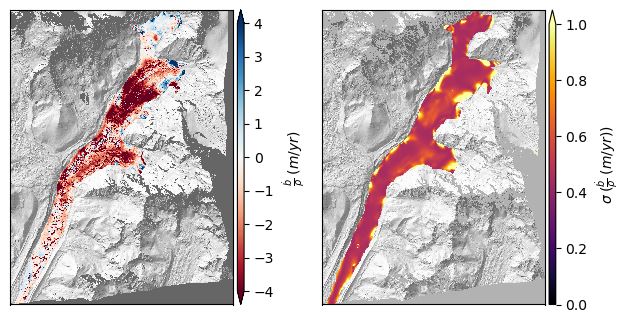

In [121]:
khumbu_smb_uncertainty = propagate_full_uncertainty(vx_fn,vy_fn,dem1_fn,dem2_fn,smb_fn,divq2_concensus_fn,glac_name=glac_name)

In [122]:

%cd /nobackup/sbhusha1/chapter2/HighresDebrisCover_SMB_Data/BlackChangriNup/SMB_data/

/nobackupp11/sbhusha1/chapter2/HighresDebrisCover_SMB_Data/BlackChangriNup/SMB_data


In [123]:
vx_fn = '20151102_combined_hs__20161025_combined_hs_mgm_disp_9spm_spm_ker15_corr_kernel9px_resmin_txm_vx_skiprate_1_gauss_fill51px_shpclip_b1.tif'
vy_fn = '20151102_combined_hs__20161025_combined_hs_mgm_disp_9spm_spm_ker15_corr_kernel9px_resmin_txm_vy_skiprate_1_gauss_fill51px_shpclip_b1.tif'
dem1_fn = '../dem/20151102_0517_10400100125E8E00_10400100130D8500_align.tif'
dem2_fn = '../dem/20161025_0524_104001002469AD00_1040010024438E00-DEM_2m_align.tif'
divq2_concensus_fn = 'black_changri_nup_farinotti_2015-11-02_to_2016-10-25_divQ2.tif'
smb_fn = 'black_changri_nup_farinotti_2015-11-02_to_2016-10-25_smb_dhdt.tif'
glac_name = 'changri_nup'


Warping all inputs to the following:
Resolution: 25.0
Extent: [476612.5, 3094162.5, 482987.5, 3099437.5]
Projection: '+proj=utm +zone=45 +datum=WGS84 +units=m +no_defs'
Resampling alg: cubic

1 of 8: 20151102_combined_hs__20161025_combined_hs_mgm_disp_9spm_spm_ker15_corr_kernel9px_resmin_txm_vx_skiprate_1_gauss_fill51px_shpclip_b1.tif
nl: 211 ns: 255 res: 25.000
100 - done.
0...10...20...30...40...50...60...70...80...90...2 of 8: 20151102_combined_hs__20161025_combined_hs_mgm_disp_9spm_spm_ker15_corr_kernel9px_resmin_txm_vy_skiprate_1_gauss_fill51px_shpclip_b1.tif
nl: 211 ns: 255 res: 25.000
100 - done.
0...10...20...30...40...50...60...70...80...90...3 of 8: /nobackupp11/sbhusha1/reference_data/farinotti_2019_ice_thickness/RGI60-15/RGI60-15.03734_thickness.tif
4 of 8: /nobackupp11/sbhusha1/reference_data//farinotti_2019_ice_thickness/model1/RGI60-15/thickness_RGI60-15.03734.tif
5 of 8: /nobackupp11/sbhusha1/reference_data//farinotti_2019_ice_thickness/model2/RGI60-15/thickness_RGI60-

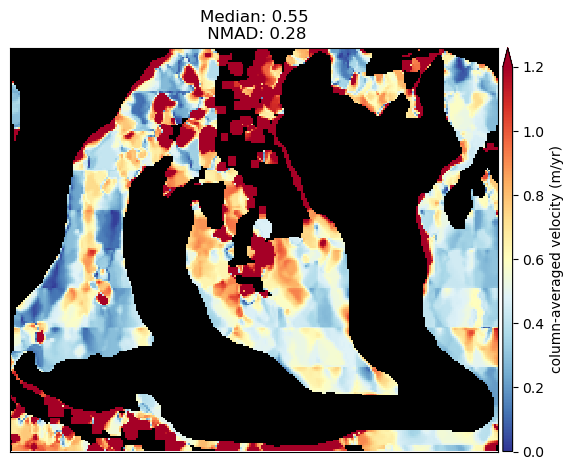

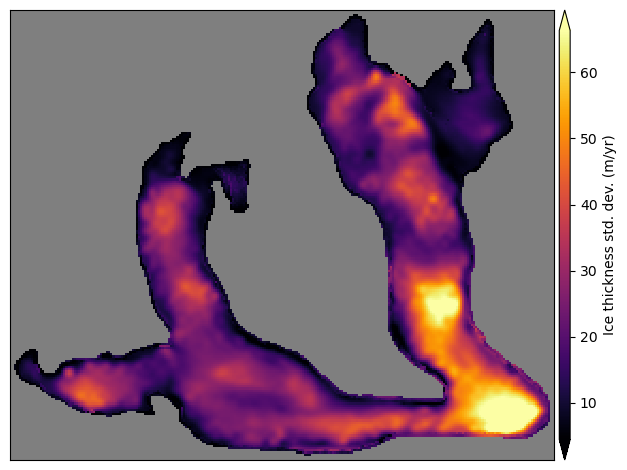

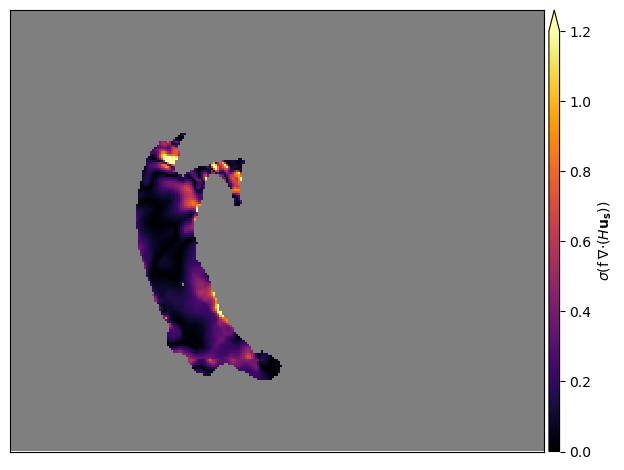

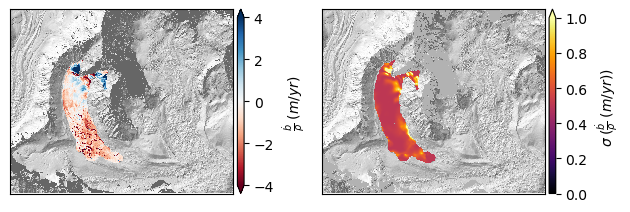

In [124]:
bcn_smb_uncertainty = propagate_full_uncertainty(vx_fn,vy_fn,dem1_fn,dem2_fn,smb_fn,divq2_concensus_fn,glac_name=glac_name)

### Uncertainty Figure Main Manuscript

In [125]:
glaciers = ['lirung','langtang','ngozumpa','changri_nup','khumbu','imja']
titles = ['A. Lirung', 'B. Langtang', 'C. Ngozumpa', 'D. Black Changri Nup', 'E. Khumbu', 'F. Imja Lhotse Shar']

In [126]:
%cd /nobackup/sbhusha1/chapter2/HighresDebrisCover_SMB_Data/

/nobackupp11/sbhusha1/chapter2/HighresDebrisCover_SMB_Data


In [128]:
lirung_dem_fn = 'Lirung/dem/20161106_0456_103001005FAB7A00_103001005F7EBB00-DEM_2m_align.tif'
lirung_smb_fn = 'Lirung/SMB_data/lirung_farinotti_2016-11-06_to_2017-12-22_smb_dhdt.tif'
lirung_smb_uncertainty_fn = 'Lirung/SMB_data/lirung_farinotti_2016-11-06_to_2017-12-22_smb_dhdt_smb_propagated_uncertainty.tif'
lirung_ds_list = warplib.memwarp_multi_fn([lirung_dem_fn,lirung_smb_fn,lirung_smb_uncertainty_fn],extent='last')

#Langtang
dem_fn = 'Langtang/dem/20150222_0504_1040010008B92D00_10400100087E2400-DEM_2m_align.tif'
smb_fn = 'Langtang/SMB_data/langtang_farinotti_2015-02-22_to_2016-01-07_smb_dhdt.tif'
smb_uncertainty_fn = 'Langtang/SMB_data/langtang_farinotti_2015-02-22_to_2016-01-07_smb_dhdt_smb_propagated_uncertainty.tif'
langtang_ds_list = warplib.memwarp_multi_fn([dem_fn,smb_fn,smb_uncertainty_fn],extent='last')

#Ngozumpa
dem_fn = 'Ngozumpa/dem/20121223_0456_1050410000E0AE00_1050410000E8C900-DEM_2m.tif'
smb_fn = 'Ngozumpa/SMB_data/ngozumpa_farinotti_2012-12-23_to_2015-01-15_smb_dhdt.tif'
smb_uncertainty_fn =  os.path.splitext(smb_fn)[0]+'_smb_propagated_uncertainty.tif'
ngozumpa_ds_list = warplib.memwarp_multi_fn([dem_fn,smb_fn,smb_uncertainty_fn],extent='last')

# bcn
dem_fn = 'BlackChangriNup/dem/20151102_0517_10400100125E8E00_10400100130D8500_align.tif'
smb_fn = 'BlackChangriNup/SMB_data/black_changri_nup_farinotti_2015-11-02_to_2016-10-25_smb_dhdt.tif'
smb_uncertainty_fn =  os.path.splitext(smb_fn)[0]+'_smb_propagated_uncertainty.tif'
bcn_ds_list = warplib.memwarp_multi_fn([dem_fn,smb_fn,smb_uncertainty_fn],extent='last')

#khumbu
dem_fn = 'Khumbu/dem/20151102_0517_10400100125E8E00_10400100130D8500_align.tif'
smb_fn = 'Khumbu/SMB_data/khumbu_farinotti_2015-11-02_to_2016-10-25_smb_dhdt.tif'
smb_uncertainty_fn =  os.path.splitext(smb_fn)[0]+'_smb_propagated_uncertainty.tif'
khumbu_ds_list = warplib.memwarp_multi_fn([dem_fn,smb_fn,smb_uncertainty_fn],extent='last')

#imja
dem_fn = 'ImjaLhotseShar/dem/20151002_0651_10200100457F0C00_1020010042C0CE00-DEM_2m.tif'
smb_fn = 'ImjaLhotseShar/SMB_data/imja_farinotti_2015-10-02_to_2016-10-29_smb_dhdt.tif'
smb_uncertainty_fn =  os.path.splitext(smb_fn)[0]+'_smb_propagated_uncertainty.tif'
imja_ds_list = warplib.memwarp_multi_fn([dem_fn,smb_fn,smb_uncertainty_fn],extent='last')

mega_ds_list = [lirung_ds_list,langtang_ds_list,ngozumpa_ds_list,bcn_ds_list,khumbu_ds_list,imja_ds_list]


Warping all inputs to the following:
Resolution: 2.0
Extent: [357337.5, 3122713.5, 359213.5, 3126237.5]
Projection: '+proj=utm +zone=45 +datum=WGS84 +units=m +no_defs'
Resampling alg: cubic

1 of 3: Lirung/dem/20161106_0456_103001005FAB7A00_103001005F7EBB00-DEM_2m_align.tif
nl: 1762 ns: 938 res: 2.000
100 - done.
0...10...20...30...40...50...60...70...80...90...2 of 3: Lirung/SMB_data/lirung_farinotti_2016-11-06_to_2017-12-22_smb_dhdt.tif
nl: 1762 ns: 938 res: 2.000
100 - done.
0...10...20...30...40...50...60...70...80...90...3 of 3: Lirung/SMB_data/lirung_farinotti_2016-11-06_to_2017-12-22_smb_dhdt_smb_propagated_uncertainty.tif

Warping all inputs to the following:
Resolution: 2.0
Extent: [368087.5, 3121737.5, 375911.5, 3139937.5]
Projection: '+proj=utm +zone=45 +datum=WGS84 +units=m +no_defs'
Resampling alg: cubic

1 of 3: Langtang/dem/20150222_0504_1040010008B92D00_10400100087E2400-DEM_2m_align.tif
nl: 9100 ns: 3912 res: 2.000
100 - done.
0...10...20...30...40...50...60...70...80.

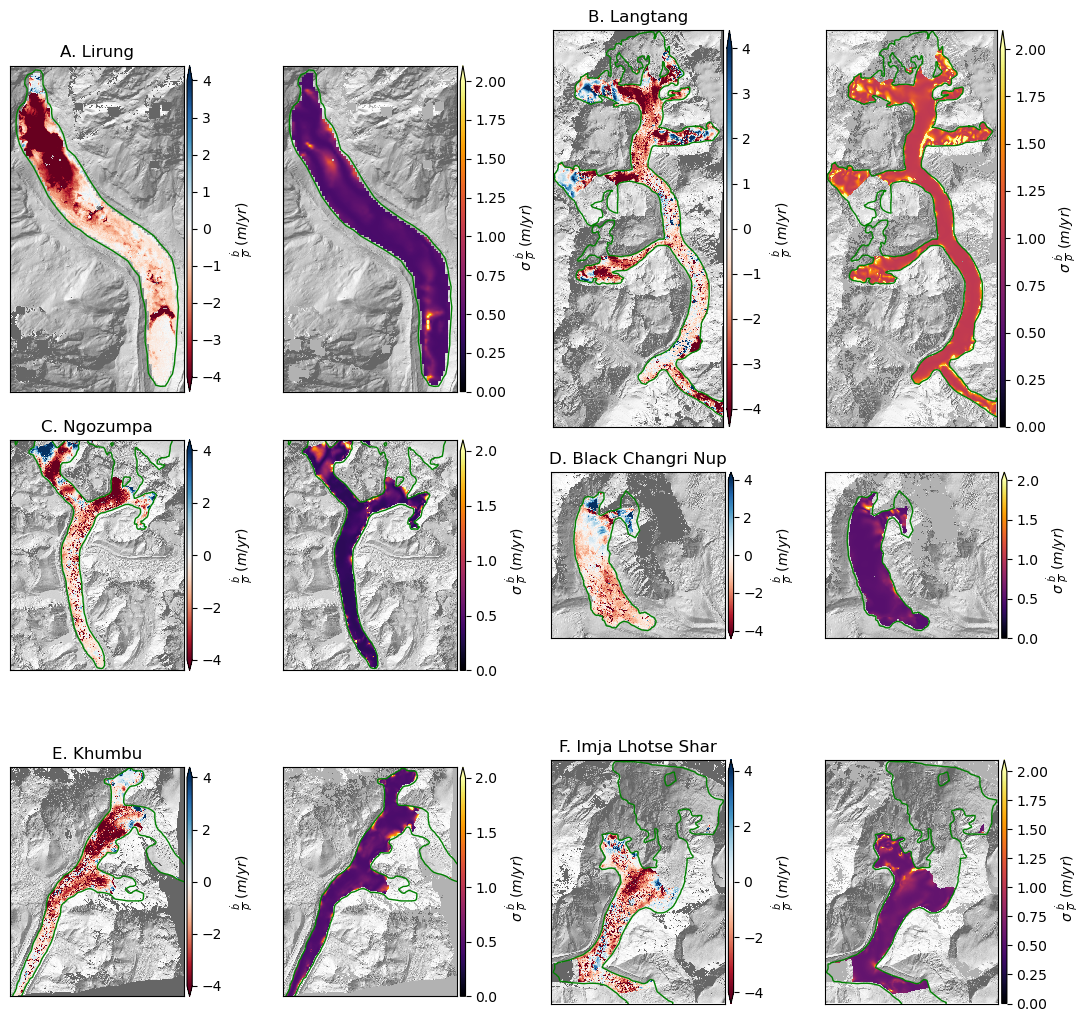

In [137]:
fig = plt.figure(figsize=(11, 11))
outer = gridspec.GridSpec(3, 2)
for i,glacier in enumerate(glaciers):
    inner = gridspec.GridSpecFromSubplotSpec(1, 2,
                    subplot_spec=outer[i],wspace=0.5, hspace=0.5)
    
    #thick,thick_std,gdf,fig_extent = fetch_thickness_and_std_and_shp(glacier)
    ds_list = mega_ds_list[i]
    dem,smb,smb_uncertainty = [iolib.ds_getma(ds) for ds in ds_list]
    ds_extent = geolib.ds_extent(ds_list[0])
    fig_extent = [ds_extent[0],ds_extent[2],ds_extent[1],ds_extent[3]]
    gdf = gpd.read_file(constants.fetch_glac_shp(constants.rgi_dicts[glacier])).to_crs('EPSG:32645')
    if glacier == 'changri_nup':
        gdf = gpd.read_file('/nobackup/sbhusha1/hma/agu22_scratch/Black_changri_with_accumulation_area2.shp').to_crs('EPSG:32645')
        #thick,thick_std,gdf,fig_extent = fetch_thickness_and_std_and_shp(glacier,'/nobackup/sbhusha1/hma/agu22_scratch/Black_changri_with_accumulation_area2.shp')
        #thick = malib.ndv_trim(thick)
        #thick_std = malib.ndv_trim(thick_std)
        

    ax = plt.Subplot(fig, inner[0])   
    fig.add_subplot(ax)

    pltlib.iv(smb,ax=ax,cmap='RdBu',clim=(-4,4),hillshade=True,ds=ds_list[0],scalebar=False,extent=fig_extent,
          skinny=False,label=r'$\frac{\dot{b}}{\rho}\;(m/yr)$ ',full_bg_stretch=False,overlay_alpha=1,title=titles[i])
    
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    if glacier == 'changri_nup':
        xlim = (477599.7040301451, 481379.6298482157)
        ylim = (3094811.880500241, 3098430.95841116)
    gdf.plot(ax=ax,edgecolor='green',facecolor='None',linewidth=1)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    ax = plt.Subplot(fig, inner[1])   
    fig.add_subplot(ax)
    pltlib.iv(smb_uncertainty,ax=ax,cmap='inferno',clim=(0,2),hillshade=True,ds=ds_list[0],scalebar=False,extent=fig_extent,
          skinny=False,label=r'$\sigma\;{\frac{\dot{b}}{\rho}}\;(m/yr)$ ',full_bg_stretch=False,overlay_alpha=1)
    
    gdf.plot(ax=ax,edgecolor='green',facecolor='None',linewidth=1)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    #inner.set_title(glacier)
plt.tight_layout()
fig.savefig('/nobackup/sbhusha1/chapter2/figures/SMB_uncertainty_main_manuscript.png',dpi=300,bbox_inches='tight',pad_inches=0.1)


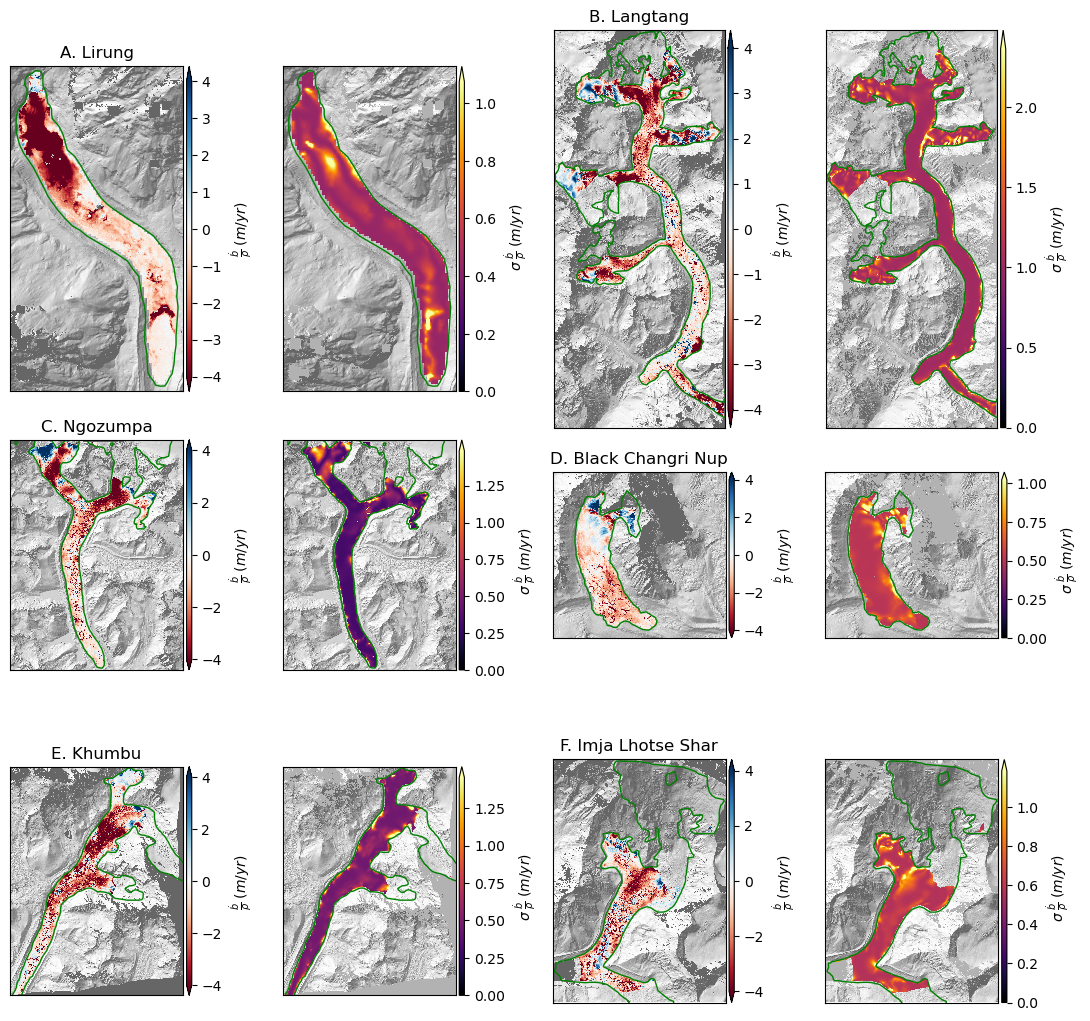

In [139]:
fig = plt.figure(figsize=(11, 11))
outer = gridspec.GridSpec(3, 2)
for i,glacier in enumerate(glaciers):
    inner = gridspec.GridSpecFromSubplotSpec(1, 2,
                    subplot_spec=outer[i],wspace=0.5, hspace=0.5)
    
    #thick,thick_std,gdf,fig_extent = fetch_thickness_and_std_and_shp(glacier)
    ds_list = mega_ds_list[i]
    dem,smb,smb_uncertainty = [iolib.ds_getma(ds) for ds in ds_list]
    ds_extent = geolib.ds_extent(ds_list[0])
    fig_extent = [ds_extent[0],ds_extent[2],ds_extent[1],ds_extent[3]]
    gdf = gpd.read_file(constants.fetch_glac_shp(constants.rgi_dicts[glacier])).to_crs('EPSG:32645')
    if glacier == 'changri_nup':
        gdf = gpd.read_file('/nobackup/sbhusha1/hma/agu22_scratch/Black_changri_with_accumulation_area2.shp').to_crs('EPSG:32645')
        #thick,thick_std,gdf,fig_extent = fetch_thickness_and_std_and_shp(glacier,'/nobackup/sbhusha1/hma/agu22_scratch/Black_changri_with_accumulation_area2.shp')
        #thick = malib.ndv_trim(thick)
        #thick_std = malib.ndv_trim(thick_std)
        

    ax = plt.Subplot(fig, inner[0])   
    fig.add_subplot(ax)

    pltlib.iv(smb,ax=ax,cmap='RdBu',clim=(-4,4),hillshade=True,ds=ds_list[0],scalebar=False,extent=fig_extent,
          skinny=False,label=r'$\frac{\dot{b}}{\rho}\;(m/yr)$ ',full_bg_stretch=False,overlay_alpha=1,title=titles[i])
    
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    if glacier == 'changri_nup':
        xlim = (477599.7040301451, 481379.6298482157)
        ylim = (3094811.880500241, 3098430.95841116)
    gdf.plot(ax=ax,edgecolor='green',facecolor='None',linewidth=1)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    ax = plt.Subplot(fig, inner[1])   
    fig.add_subplot(ax)
    clim = (0,np.percentile(smb_uncertainty.compressed(),98))
    pltlib.iv(smb_uncertainty,ax=ax,cmap='inferno',clim=clim,hillshade=True,ds=ds_list[0],scalebar=False,extent=fig_extent,
          skinny=False,label=r'$\sigma\;{\frac{\dot{b}}{\rho}}\;(m/yr)$ ',full_bg_stretch=False,overlay_alpha=1)
    
    gdf.plot(ax=ax,edgecolor='green',facecolor='None',linewidth=1)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    #inner.set_title(glacier)
plt.tight_layout()
fig.savefig('/nobackup/sbhusha1/chapter2/figures/SMB_uncertainty_main_manuscript_variable_clim.png',dpi=300,bbox_inches='tight',pad_inches=0.1)
